# Deriving formant estimates from the VTRs

We estimate formant center frequency and bandwidth using the spectral envelope of the VT transfer function containing the VTRs.

To get this envelope, we use heuristics: smoothing (essentially low-pass filtering) and peak-picking. Error bars are obtained by repeating this procedure for each sample from the VT transfer function posterior.

Our heuristics are similar to Hanna (2016):

> [T]he approximate location of the maxima
and minima of the impedance spectra were identified with a
sixth order Savitzky–Golay smoothing filter (Savitzky and
Golay, 1964). Parabolas were fitted to both sides of each of
the extrema and their crossover point used to determine the
frequency f and the impedance magnitude jZj. The bandwidth B was
determined as the frequency range at half maximum power. (p. 2927)

We use olny a second order (parabola-fitting) Savitzky–Golay filter to smooth the spectrum, since it is already so smooth. This kind of smoothing is very much like simple low-pass filtering (we also tried a second-order Butterworth filter with similar results but harder-to-interpret parameters) and the connection to cepstral processing is clear.

Thus $B$ is determined from the FWHM, or -3 dB from the local maximum of the power spectral envelope. This is standard practice for researchers measuring directly from the spectral envelope (rather than root-solving procedures as e.g. advocated by Fulup 2011 and used e.g. by Praat) and underlies the empirical data used for the Hawks relationship.

In [87]:
%run init.ipy
import scipy.signal
from vtr import peak
from vtr.prior import allpole
from vtr.prior import bandwidth
from dgf import core

In [88]:
num_freq = 2500
f, df = np.linspace(0, 5000., num_freq, retstep=True)

In [89]:
prior = bandwidth.TFB_prior()

def sample_power_spectrum_dB(K=3, key=None):
    key = key if key is not None else jaxkey()
    T, *xy = prior.sample(seed=key)
    xy = np.array(xy)
    x, y = np.split(xy, 2)
    x = x[:K]
    y = y[:K]
    poles = core.make_poles(y, x)
    power = allpole.transfer_function_power_dB(f/1000, poles)
    return key, x, y, power

[Memory]4520.5s, 75.3min: Loading get_vtrformants_training_data...
[Memory]4521.2s, 75.4min: Loading run_nested...
[Memory]4521.6s, 75.4min: Loading run_nested...


[      0 5756143]
F = [851.35965546]
F^ = [851.00013616]
B = [51.14281909]
B^ = [51.22280644]


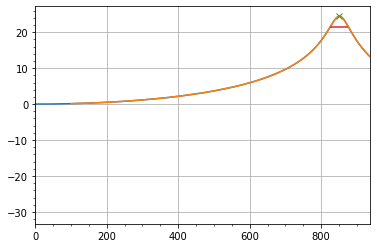

In [92]:
FILTER_WINDOW_LENGTH = 250 # Hz
PEAK_PROMINENCE = 3. # dB
PEAK_DISTANCE = 200 # Hz
FWHM_POWER_DROP = 3. # dB

key, x, y, power = sample_power_spectrum_dB(1, jaxkey())

print(key)

#output = scipy.signal.savgol_filter(power, peak.get_polyorder(FILTER_WINDOW_LENGTH, df), 2)
output = power

df_new = 1 # Hz

output_up, f_up = scipy.signal.resample(output, int(len(output)*df/df_new), f, window='hamming')
accept = (100 <= f_up) & (f_up <= 5000)
output_up = output_up[accept]
f_up = f_up[accept]

peaks, _ = scipy.signal.find_peaks(output_up, distance=PEAK_DISTANCE // df, prominence=PEAK_PROMINENCE)

_, left_bases, right_bases = scipy.signal.peak_prominences(output_up, peaks)
prominences = np.repeat(FWHM_POWER_DROP, len(peaks))
prominence_data = (prominences, left_bases, right_bases)

bandwidths, width_heights, left_lps, right_lps = scipy.signal.peak_widths(output_up, peaks, rel_height=1, prominence_data=prominence_data)

formant_center = f_up[peaks]

print("F =", x)
print("F^ =", formant_center)
print("B =", y)
print("B^ =", bandwidths)

plot(f, power)
plot(f_up, output_up)
plot(formant_center, output_up[peaks], "x")
plt.hlines(width_heights, interp(left_lps, arange(len(f_up)), f_up), interp(right_lps, arange(len(f_up)), f_up), color="C3")

plt.grid("on")
plt.minorticks_on()

xlim(0, x[-1]*1.1);
#ylim(-20, None);


In [13]:
output_up[-5:]

array([-67.02299329, -65.65027802, -64.18148638, -62.61887243,
       -60.96556029])